# Opmap analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import copy
import cv2
import math
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

In [2]:
import sys
sys.path.append("./opmap/opmap")

In [26]:
from RawCam import RawCam
from VmemMap import VmemMap
from PhaseMap import PhaseMap
from BrayPSMap import BrayPSMap
from PhaseVarianceMap import PhaseVarianceMap
from PhaseVariancePeakMap import PhaseVariancePeakMap
from util import makeMovie

## parameters

In [4]:
exp_dir = "/mnt/recordings/ExperimentData/"
anl_dir = "/mnt/recordings/AnalysisResult/Tomii/2017-12-20/"

df_path = "./list.csv"

delay = 5

pv_thre = 0.7

## functions

In [5]:
def show_session(s):
    for key in s.keys(): 
        print "{0}:{1}".format(key, s[key])

In [36]:
def integrate_all(cam, vmem, pmap, pvmap, stim_x, stim_y ):
    
    shape = pvmap.data.shape
    phase_wf = -2.0
    phase_wt = 2.0
    phase_w = 0.1
    step = vmem.data.shape[1] /  pvmap.data.shape[1] 
    
    rgb_img = np.zeros( (shape[0]-delay, shape[1], shape[2], 3), dtype=np.uint8)
    
    #------------------
    # Camera
    #------------------
    img_cam = (  (cam.data[delay:,::step,::step] - cam.vmin) / (cam.vmax-cam.vmin)*96 ).astype(np.uint8)
    rgb_img[:,:,:,0] = img_cam
    rgb_img[:,:,:,1] = img_cam
    rgb_img[:,:,:,2] = img_cam
    
    #------------------
    # Vmem
    #------------------
    rgb_img[:,:,:,2] = ( (vmem.data[delay:,::step,::step]-vmem.vmin)*0.5*255 ).astype(np.uint8)
    #rgb_img[:,:,:,2] = 127 + ( vmem.data[delay:,::step,::step]*128 ).astype(np.uint8)
    #rgb_img[:,:,:,0] = 127 + ( - vmem.data[delay:,::step,::step]*128 ).astype(np.uint8)
    
    #------------------
    # WF
    #------------------
#     mask = (( np.abs( pmap.data - phase_wf ) < phase_w )*1.0).astype(np.uint8)[:-delay,:,:]
#     for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
#     rgb_img[:,:,:,1] += mask*255

    #------------------
    # WT
    #------------------
#     mask = (( np.abs( pmap.data - phase_wt ) < phase_w )*1.0).astype(np.uint8)[:-delay,:,:]
#     for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
#     rgb_img[:,:,:,0] += mask*255
#     rgb_img[:,:,:,2] += mask*255
    
    #------------------
    # ROI
    #------------------
    for i in range(shape[0]-delay) : 
        for c in range(3):
            rgb_img[i,:,:,c] *= pvmap.roi[:,:].astype(np.uint8)
        
    #------------------
    # PS (#FFFFFF)
    #------------------
    mask = (( pvmap.data > pv_thre )*1.0).astype(np.uint8)[:-delay,:,:]
    for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    for i in range(3) : rgb_img[:,:,:,i] += mask*(255*pvmap.data[:-delay,:,:]).astype(np.uint8)
        
    #------------------
    # Stim point (#FFFF00)
    #------------------
    mask = np.zeros( (shape[0]-delay, shape[1], shape[2]), dtype=np.uint8 )
    mask[ :, stim_y-1:stim_y+2, stim_x-1:stim_x+2 ] = 1
    for i in range(3) : rgb_img[:,:,:,i] *= (1-mask)
    rgb_img[:,:,:,2] += (mask*255).astype(np.uint8)
    rgb_img[:,:,:,1] += (mask*255).astype(np.uint8)        
    
    return rgb_img

## load data frame

In [27]:
df = pd.read_csv(df_path)
print "N:",len(df)
df

N: 37


,sample,session,frame_stim,speed,pre_x,pre_y,stim_x,stim_y,distance,stim_phase,sw_induced,sw_collision,sw_sustained,fb_angle,stim_angle
0,20160907-3,6,295,1575,106.50,84.50,86,68,16.708187,2.85,True,True,False,1.555173,0.877464
1,20160907-3,10,354,1575,59.00,68.00,86,68,17.142857,0.99,True,True,True,1.555173,1.555173
2,20160907-3,11,405,1575,102.00,75.50,86,68,11.219427,2.51,True,True,False,1.555173,1.116836
3,20160907-3,17,355,1575,87.00,73.00,86,68,3.237473,1.16,True,True,False,1.555173,0.084045
4,20160907-3,22,325,1575,80.33,62.67,86,68,4.940882,1.47,True,True,True,1.555173,1.497037
5,20161019-1,19,380,1214,89.50,80.50,83,75,7.013751,-2.17,False,False,False,0.960070,0.257813
6,20161019-2,6,320,1500,52.50,26.00,62,54,19.711813,-1.04,False,False,False,1.570796,0.327098
7,20161019-2,7,160,1252,41.60,86.20,52,66,18.146993,-2.58,True,True,True,1.570796,0.475458
8,20161019-2,8,140,1252,37.67,86.33,52,66,19.866480,1.73,True,True,True,1.570796,0.613987
9,20161019-2,9,190,1252,41.50,68.00,52,66,8.537364,-0.98,False,False,False,1.570796,1.382575


## Main session loop

In [48]:
#for i in range(len(df)):
for i in [27]:
    
    s = df.loc[i,:]
    
    sample = s["sample"]
    session = s["session"]
    target = "{0}/{1}/C001H001S{2:0>4}".format(exp_dir, sample, session)    
    save_dir = target.replace(exp_dir, anl_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    print "{0}:{1}".format(i, target)
    
    if 'cam' in locals() : del(cam)
    if 'vmem' in locals() : del(vmem)
    if 'pmap' in locals() : del(pmap)
        
    cam = RawCam(
        path = target,
        cam_type = 'sa4', 
        image_height = 512, image_width = 512, 
        frame_start = 0, frame_end = 500 )
    vmem = VmemMap( cam )
    vmem_ = copy.deepcopy(vmem)
    vmem_.setDiffRange(diff_min=64)
    vmem_.morphROI(closing=12)
    vmem_.morphROI(erosion=6)
    vmem_.smooth(15)
    pmap = PhaseMap( vmem_ )
    pvmap = PhaseVarianceMap( pmap, size=5 )
    #pvmap.data = (pvmap.data > 0.8)*1.0
    bmap = BrayPSMap(pmap, thre=0.95)
    rgb_pv = integrate_all(cam, vmem_, pmap, pvmap=pvmap, stim_x=s["stim_x"], stim_y=s["stim_y"])
    rgb_b   = integrate_all(cam, vmem_, pmap, pvmap=bmap, stim_x=s["stim_x"], stim_y=s["stim_y"])

    dirs = []
    
#     d = os.path.join( save_dir , "pvmap"); pvmap.saveImage(d); dirs.append(d)
#     d = os.path.join( save_dir , "bmap"); bmap.saveImage(d); dirs.append(d)

    d = os.path.join( save_dir , "all_pv")
    if not os.path.exists(d) : os.mkdir(d)
    for i, img in enumerate(rgb_pv):
        #im = plt.imshow(img)
        #plt.savefig(os.path.join(d, "{0:0>6}.png".format(i)))
        cv2.putText(img,"{0:0>4}ms".format(i), (4,16), cv2.FONT_HERSHEY_PLAIN, 0.6, (255,255,255))
        cv2.imwrite(os.path.join(d, "{0:0>6}.png".format(i)), img)
    dirs.append(d)

    d = os.path.join( save_dir , "all_b")
    if not os.path.exists(d) : os.mkdir(d)
    for i, img in enumerate(rgb_b):
        #im = plt.imshow(img)
        #plt.savefig(os.path.join(d, "{0:0>6}.png".format(i)))
        cv2.putText(img,"{0:0>4}ms".format(i), (4,16), cv2.FONT_HERSHEY_PLAIN, 0.6, (255,255,255))
        cv2.imwrite(os.path.join(d, "{0:0>6}.png".format(i)), img)
    dirs.append(d)

    for d in dirs: makeMovie(d)


27:/mnt/recordings/ExperimentData//20161021-1/C001H001S0009
ffmpeg -r 15 -y -i "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_pv/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_pv.mp4"
ffmpeg -r 15 -y -i "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_b/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_b.mp4"


In [49]:
d = os.path.join( save_dir , "all_pv"); makeMovie(d)
d = os.path.join( save_dir , "all_b"); makeMovie(d)

ffmpeg -r 15 -y -i "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_pv/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_pv.mp4"
ffmpeg -r 15 -y -i "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_b/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Tomii/2017-12-20//20161021-1/C001H001S0009/all_b.mp4"


In [52]:
from PIL import Image

/home/tomii/.pyenv/versions/anaconda2-4.4.0/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


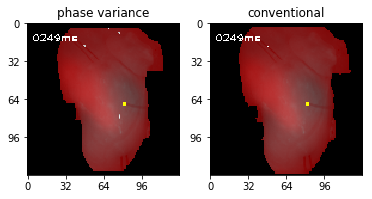

In [70]:
d = os.path.join(anl_dir, "plot")
if not os.path.exists(d) : os.mkdir(d)
    
for i, n in enumerate(np.arange(150, 250)):

    img_pv = Image.open(os.path.join(save_dir, "all_pv/{0:0>6}.png".format(n)))
    img_b  = Image.open(os.path.join(save_dir, "all_b/{0:0>6}.png".format(n)))

    plt.subplot(121)
    plt.imshow(img_pv)
    plt.xticks(np.arange(0,128,32))
    plt.yticks(np.arange(0,128,32))
    plt.title("phase variance")
    plt.subplot(122)
    plt.imshow(img_b)
    plt.xticks(np.arange(0,128,32))
    plt.yticks(np.arange(0,128,32))
    plt.title("conventional")

    plt.savefig(os.path.join(d, "{0:0>6}.png".format(i)))

In [73]:
! ffmpeg -r 5 -y -i "/mnt/recordings/AnalysisResult/Tomii/2017-12-20/plot/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "/mnt/recordings/AnalysisResult/Tomii/2017-12-20/plot.mp4"

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e